In [ ]:
import numpy as np
import plotly.graph_objects as go
from collections import deque, Counter


class BeliefFilter:
	"""
	Generates a predictive belief curve using a history-aware
	'inject and decay' filter.
	"""

	def __init__(
		self,
		belief_horizon: int,
		memory_size: int,
		decay_rate: float,
		gaussian_sigma: float,
		gaussian_amplitude: float,
	):
		self.belief_horizon = belief_horizon
		self.memory_size = memory_size
		self.decay_rate = decay_rate
		self.gaussian_sigma = gaussian_sigma
		self.gaussian_amplitude = gaussian_amplitude

	def _getBestPeriod(self, interval_memory: deque):
		"""Determines the most probable period from the interval memory."""
		if not interval_memory:
			return None
		# Find the most common interval (the mode) in our recent history.
		mode_result = Counter(interval_memory).most_common(1)
		return mode_result[0][0]

	def processSignal(self, signal: np.ndarray):
		"""Processes an entire signal and returns the predictive belief curve."""
		prior_output = np.zeros_like(signal, dtype=float)
		belief_curve = np.zeros(self.belief_horizon, dtype=float)
		interval_memory = deque(maxlen=self.memory_size)
		last_pulse_time = -1

		# Pre-calculate the x-axis for the Gaussian kernel for efficiency.
		gaussian_x = np.arange(self.belief_horizon)

		for t, value in enumerate(signal):
			# 1. Record the current belief for this time step.
			prior_output[t] = belief_curve[0]

			# 2. Time passes: shift belief curve left and decay its values.
			belief_curve = np.roll(belief_curve, -1)
			belief_curve[-1] = 0
			belief_curve *= self.decay_rate

			# 3. If a pulse is observed, update our model.
			if value == 1:
				if last_pulse_time != -1:
					delta_t = t - last_pulse_time
					interval_memory.append(delta_t)

				last_pulse_time = t

				# 4. Inject a new belief based on historical wisdom.
				best_period = self._getBestPeriod(interval_memory)
				if best_period is not None and best_period < self.belief_horizon:
					# Create a Gaussian kernel centered at the best period.
					kernel = self.gaussian_amplitude * np.exp(
						-((gaussian_x - best_period) ** 2) / (2 * self.gaussian_sigma**2)
					)
					belief_curve += kernel

			# Ensure the belief doesn't grow uncontrollably.
			np.clip(belief_curve, 0, 1.0, out=belief_curve)

		return prior_output


# --- Main Execution ---
def generateSyntheticData(regimes, miss_prob=0.0, false_alarm_prob=0.0):
	# (Implementation unchanged)
	true_signal = []
	for num_events, period in regimes:
		for _ in range(num_events):
			true_signal.extend([0] * (period - 1))
			true_signal.append(1)
	true_signal = np.array(true_signal, dtype=int)
	if miss_prob == 0 and false_alarm_prob == 0:
		return true_signal, true_signal
	observed_signal = true_signal.copy()
	true_ones_indices = np.where(true_signal == 1)[0]
	miss_mask = np.random.rand(len(true_ones_indices)) < miss_prob
	indices_to_flip_to_zero = true_ones_indices[miss_mask]
	observed_signal[indices_to_flip_to_zero] = 0
	true_zeros_indices = np.where(true_signal == 0)[0]
	false_alarm_mask = np.random.rand(len(true_zeros_indices)) < false_alarm_prob
	indices_to_flip_to_one = true_zeros_indices[false_alarm_mask]
	observed_signal[indices_to_flip_to_one] = 1
	return observed_signal, true_signal


if __name__ == "__main__":
	SIGNAL_REGIMES = [
		(25, 30),	# 25 events with period 30
		(20, 70),	# 20 events with period 70
		(30, 45),	# 30 events with period 45
	]

	observed_signal, true_signal = generateSyntheticData(
		SIGNAL_REGIMES, miss_prob=0, false_alarm_prob=0	# zero prob for initial testing
	)

	# Filter Parameters
	BELIEF_HORIZON = 200	# How far to look into the future.
	MEMORY_SIZE = 15	# How many intervals to remember.
	DECAY_RATE = 0.995	# How quickly belief fades.
	GAUSSIAN_SIGMA = 2.5	# The "fuzziness" of the prediction.
	GAUSSIAN_AMPLITUDE = 0.6	# The strength of belief injection.

	# 1. Generate Data
	# 2. Process with the Belief Filter
	belief_filter = BeliefFilter(
		belief_horizon=BELIEF_HORIZON,
		memory_size=MEMORY_SIZE,
		decay_rate=DECAY_RATE,
		gaussian_sigma=GAUSSIAN_SIGMA,
		gaussian_amplitude=GAUSSIAN_AMPLITUDE,
	)
	prior_curve = belief_filter.processSignal(observed_signal)

	# 3. Create interactive plot with Plotly
	fig = go.Figure()
	timestamps = np.arange(len(observed_signal))

	fig.add_trace(
		go.Scatter(
			x=timestamps,
			y=prior_curve,
			mode="lines",
			name="Predictive Belief",
			line=dict(color="mediumpurple", width=2),
		)
	)

	observed_pulse_times = timestamps[observed_signal == 1]
	for t in observed_pulse_times:
		fig.add_shape(
			type="line",
			x0=t,
			y0=0,
			x1=t,
			y1=1,
			line=dict(color="rgba(192, 192, 192, 0.6)", width=1.5),
		)
	fig.add_trace(
		go.Scatter(
			x=[None],
			y=[None],
			mode="lines",
			name="Observed Pulse",
			line=dict(color="rgba(192, 192, 192, 0.9)", width=4),
		)
	)

	fig.update_layout(
		title="Predictive Belief Curve",
		xaxis_title="Time Step",
		yaxis_title="Belief Score",
		legend_title="Trace",
		template="plotly_white",
		yaxis_range=[0, 1],
	)

	fig.show()

In [19]:
import numpy as np
import plotly.graph_objects as go
from collections import deque


class FftPriorFilter:
	"""
	Generates a predictive prior curve using a sliding, asymmetrically-windowed FFT.
	"""

	def __init__(self, window_size: int, tau: float):
		self.window_size = window_size
		self.exp_window = self._createExponentialWindow(window_size, tau)

	def _createExponentialWindow(self, size: int, tau: float):
		"""Creates an increasing exponential window from near 0 to 1."""
		x = np.arange(size) - (size - 1)
		window = np.exp(x / tau)
		return window

	def processSignal(self, signal: np.ndarray):
		"""Processes an entire signal and returns the predictive belief curve."""
		prior_output = np.zeros_like(signal, dtype=float)
		data_window = deque(maxlen=self.window_size)

		for t, value in enumerate(signal):
			if t < self.window_size:
				data_window.append(value)
				continue

			# 1. Apply the asymmetric window to the historical data.
			windowed_data = np.array(data_window) * self.exp_window

			# 2. Compute the FFT.
			fft_result = np.fft.rfft(windowed_data)
			magnitudes = np.abs(fft_result)

			# 3. Find the dominant frequency (ignoring the DC component at index 0).
			total_ac_power = np.sum(magnitudes[1:])
			if total_ac_power < 1e-6:
				prior_output[t] = 0.0	# No periodic signal found.
				data_window.append(value)
				continue

			peak_index = np.argmax(magnitudes[1:]) + 1
			peak_magnitude = magnitudes[peak_index]

			# 4. Calculate confidence and phase from the peak.
			confidence = peak_magnitude / total_ac_power
			phase = np.angle(fft_result[peak_index])

			# 5. Reconstruct the prior for the current time step 't'.
			# The real part of the FFT component represents `A*cos(phase)`.
			reconstructed_value = np.real(fft_result[peak_index]) / peak_magnitude
			prior_output[t] = confidence * max(0, reconstructed_value)

			# 6. Update the data window for the next iteration.
			data_window.append(value)

		return prior_output


# --- Main Execution ---
def generateSyntheticData(regimes, miss_prob=0.0, false_alarm_prob=0.0):
	# (Implementation unchanged)
	true_signal = []
	for num_events, period in regimes:
		for _ in range(num_events):
			true_signal.extend([0] * (period - 1))
			true_signal.append(1)
	true_signal = np.array(true_signal, dtype=int)
	if miss_prob == 0 and false_alarm_prob == 0:
		return true_signal, true_signal
	observed_signal = true_signal.copy()
	true_ones_indices = np.where(true_signal == 1)[0]
	miss_mask = np.random.rand(len(true_ones_indices)) < miss_prob
	observed_signal[true_ones_indices[miss_mask]] = 0
	true_zeros_indices = np.where(true_signal == 0)[0]
	false_alarm_mask = np.random.rand(len(true_zeros_indices)) < false_alarm_prob
	observed_signal[true_zeros_indices[false_alarm_mask]] = 1
	return observed_signal, true_signal


if __name__ == "__main__":
	SIGNAL_REGIMES = [
		(30, 30),
		(20, 70),
		(30, 45),
	]

	# Filter Parameters
	WINDOW_SIZE = 256	# A power of 2 is optimal for FFT.
	TAU = 64.0	# Time constant for the exponential window.

	# 1. Generate Data (with noise)
	observed_signal, true_signal = generateSyntheticData(
		SIGNAL_REGIMES, miss_prob=0, false_alarm_prob=0
	)

	# 2. Process with the FFT Filter
	fft_filter = FftPriorFilter(window_size=WINDOW_SIZE, tau=TAU)
	prior_curve = fft_filter.processSignal(observed_signal)

	# 3. Create interactive plot
	fig = go.Figure()
	timestamps = np.arange(len(observed_signal))

	fig.add_trace(
		go.Scatter(
			x=timestamps,
			y=prior_curve,
			mode="lines",
			name="FFT Prior",
			line=dict(color="crimson", width=2),
		)
	)

	observed_pulse_times = timestamps[observed_signal == 1]
	for t in observed_pulse_times:
		fig.add_shape(
			type="line",
			x0=t,
			y0=0,
			x1=t,
			y1=1,
			line=dict(color="rgba(192, 192, 192, 0.6)", width=1.5),
		)
	fig.add_trace(
		go.Scatter(
			x=[None],
			y=[None],
			mode="lines",
			name="Observed Pulse",
			line=dict(color="rgba(192, 192, 192, 0.9)", width=4),
		)
	)

	fig.update_layout(
		title="Predictive Prior from Asymmetric-Windowed FFT",
		xaxis_title="Time Step",
		yaxis_title="Prior Score",
		legend_title="Trace",
		template="plotly_white",
		yaxis_range=[0, 1],
	)

	fig.show()

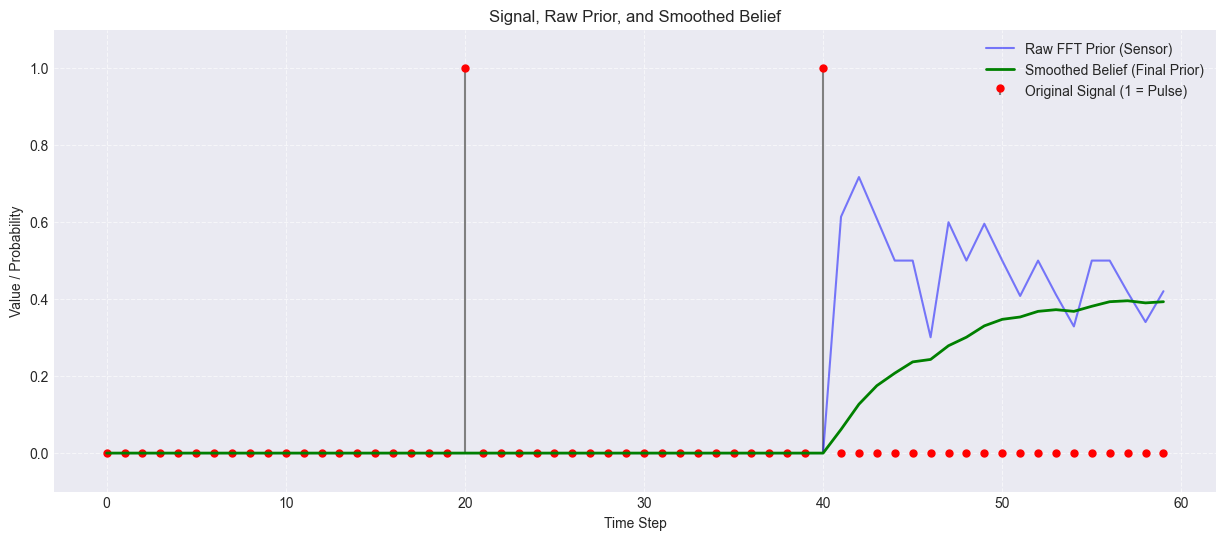

In [27]:
# ID: FftPriorPoc_Smoothed
import numpy as np
import matplotlib.pyplot as plt


def predictNextPoint(history, t):
	"""
	Predicts the signal probability for the next time step `t` based on `history`.
	"""
	n_samples = len(history)

	if np.sum(history) < 2:
		return 0.0

	fft_result = np.fft.fft(history)
	fft_freq = np.fft.fftfreq(n_samples)

	positive_freq_indices = np.where(fft_freq > 1.0 / n_samples)
	magnitudes = np.abs(fft_result[positive_freq_indices])

	if len(magnitudes) == 0:
		return 0.0

	dominant_positive_freq_index = np.argmax(magnitudes)
	peak_freq_index = positive_freq_indices[0][dominant_positive_freq_index]

	dominant_component = fft_result[peak_freq_index]
	amplitude = np.abs(dominant_component) / n_samples
	phase = np.angle(dominant_component)
	frequency = fft_freq[peak_freq_index]

	prediction = amplitude * np.cos(2 * np.pi * frequency * t + phase - np.pi / 2)

	normalized_prediction = (prediction / (amplitude + 1e-9) + 1) / 2

	return max(0, min(1, normalized_prediction))


def plotResults(signal, raw_prior, smoothed_prior=None):	# [2]
	time_steps = np.arange(len(signal))

	plt.figure(figsize=(15, 6))
	plt.title("Signal, Raw Prior, and Smoothed Belief")

	markerline, stemlines, baseline = plt.stem(
		time_steps,
		signal,
		linefmt="grey",
		markerfmt="o",
		basefmt=" ",
		label="Original Signal (1 = Pulse)",
	)
	plt.setp(markerline, "color", "red", "markersize", 5)

	plt.plot(
		time_steps,
		raw_prior,
		label="Raw FFT Prior (Sensor)",
		color="blue",
		alpha=0.5,
		linewidth=1.5,
	)

	if smoothed_prior is not None:
		plt.plot(
			time_steps,
			smoothed_prior,
			label="Smoothed Belief (Final Prior)",
			color="green",
			linewidth=2,
		)

	plt.xlabel("Time Step")
	plt.ylabel("Value / Probability")
	plt.ylim(-0.1, 1.1)
	plt.legend()
	plt.grid(True, linestyle="--", alpha=0.6)
	plt.show()


if __name__ == "__main__":
	period = 20
	n_cycles = 3
	total_samples = period * n_cycles

	input_signal = np.zeros(total_samples)

	for i in range(1, n_cycles):
		input_signal[i * period] = 1

	# input_signal[80] = 0
	# input_signal[121] = 1
	# input_signal[155] = 1

	# [1] Simulate real-time processing with exponential smoothing
	alpha = 0.1	# Smoothing factor. Lower is smoother.
	dynamic_prior = np.zeros(total_samples)
	smoothed_prior = np.zeros(total_samples)

	for t in range(1, total_samples):
		history_slice = input_signal[:t]

		# Stage 1: Get the raw prediction from our "sensor"
		raw_prediction = predictNextPoint(history_slice, t)
		dynamic_prior[t] = raw_prediction

		# Stage 2: Update our belief using the raw prediction and past belief
		last_belief = smoothed_prior[t - 1]
		new_belief = alpha * raw_prediction + (1 - alpha) * last_belief
		smoothed_prior[t] = new_belief

	plotResults(input_signal, dynamic_prior, smoothed_prior)

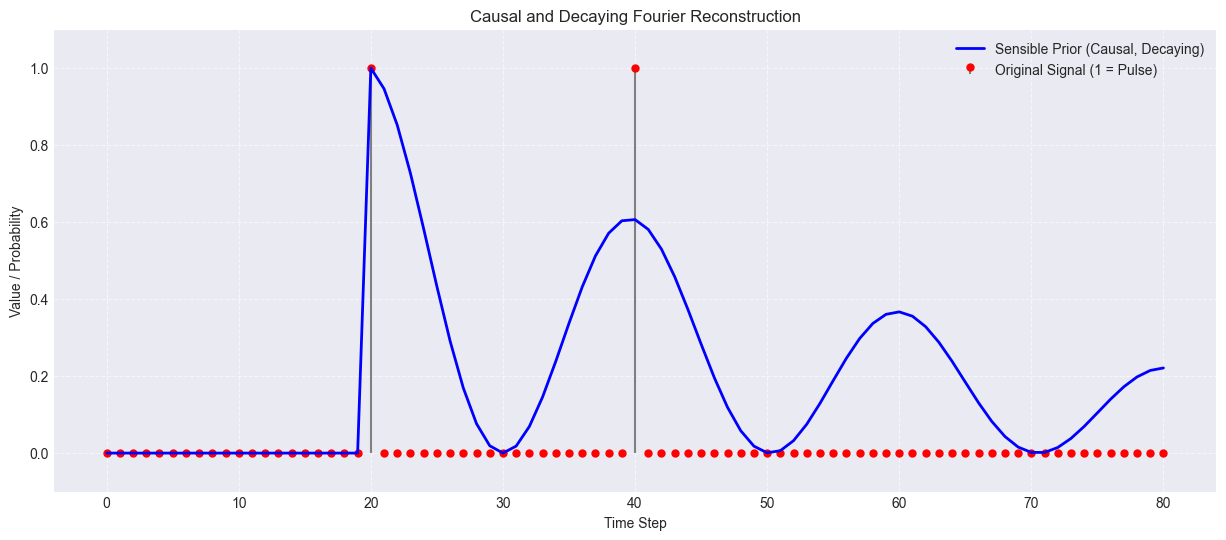

In [39]:
# ID: FftReconstructionPoc_Sensible_Corrected
import numpy as np
import matplotlib.pyplot as plt


def generatePriorFromSignal(signal_data, decay_rate=0.025):
	"""
	Computes a causal, decaying prior from a signal using FFT.
	"""
	n_samples = len(signal_data)
	if np.sum(signal_data) < 2:
		return np.zeros_like(signal_data, dtype=float)

	fft_result = np.fft.fft(signal_data)
	fft_freq = np.fft.fftfreq(n_samples)

	positive_freq_indices = np.where(fft_freq > 0)
	magnitudes = np.abs(fft_result[positive_freq_indices])

	if len(magnitudes) == 0:
		return np.zeros_like(signal_data, dtype=float)

	dominant_positive_freq_index = np.argmax(magnitudes)
	peak_freq_index = positive_freq_indices[0][dominant_positive_freq_index]

	filtered_spectrum = np.zeros_like(fft_result, dtype=complex)
	filtered_spectrum[peak_freq_index] = fft_result[peak_freq_index]
	filtered_spectrum[-peak_freq_index] = fft_result[-peak_freq_index]

	reconstructed_signal = np.fft.ifft(filtered_spectrum)
	prior_wave = reconstructed_signal.real

	min_val = np.min(prior_wave)
	max_val = np.max(prior_wave)
	if max_val > min_val:
		normalized_wave = (prior_wave - min_val) / (max_val - min_val)
	else:
		normalized_wave = np.zeros_like(prior_wave)

	first_pulse_indices = np.where(signal_data > 0)[0]
	if len(first_pulse_indices) == 0:
		return np.zeros_like(signal_data)

	first_pulse_index = first_pulse_indices[0]

	time_steps_from_start = np.arange(n_samples) - first_pulse_index
	window = np.exp(-decay_rate * time_steps_from_start)

	causality_mask = (time_steps_from_start >= 0).astype(float)

	sensible_prior = normalized_wave * window * causality_mask

	return sensible_prior


def plotResults(signal, prior):
	time_steps = np.arange(len(signal))

	plt.figure(figsize=(15, 6))
	plt.title("Causal and Decaying Fourier Reconstruction")

	markerline, stemlines, baseline = plt.stem(
		time_steps,
		signal,
		linefmt="grey",
		markerfmt="o",
		basefmt=" ",
		label="Original Signal (1 = Pulse)",
	)
	plt.setp(markerline, "color", "red", "markersize", 5)

	plt.plot(
		time_steps,
		prior,
		label="Sensible Prior (Causal, Decaying)",
		color="blue",
		linewidth=2,
	)

	plt.xlabel("Time Step")
	plt.ylabel("Value / Probability")
	plt.ylim(-0.1, 1.1)
	plt.legend()
	plt.grid(True, linestyle="--", alpha=0.6)
	plt.show()


if __name__ == "__main__":
	period = 20
	n_cycles = 4
	total_samples = period * n_cycles

	# [1] Correctly create an array of size `total_samples + 1`
	input_signal = np.zeros(total_samples + 1)

	# Pulses at t=20, t=40
	for i in range(1, 3):
		input_signal[i * period] = 1

	# input_signal[45] = 1
	# input_signal[60] = 1
	# input_signal[75] = 1

	reconstructed_prior = generatePriorFromSignal(input_signal)
	plotResults(input_signal, reconstructed_prior)

In [8]:
# ID: TrueFullReconstruction_Plotly
import numpy as np
import plotly.graph_objects as go	# [1]


def fullFourierReconstruction(signal_data):
	"""
	Performs a full, literal Fourier reconstruction with no filtering.
	This is equivalent to an identity operation.
	"""
	fft_result = np.fft.fft(signal_data)
	reconstructed_signal = np.fft.ifft(fft_result)
	n_samples = len(signal_data)
	first_pulse_indices = np.where(signal_data > 0)[0]
	first_pulse_index = first_pulse_indices[0]

	time_steps_from_start = np.arange(n_samples) - first_pulse_index
	decay_rate = 0.025
	window = np.exp(-decay_rate * time_steps_from_start)

	# return reconstructed_signal.real * window
	return fft_result.real
	return fft_result.real


def plotResults(signal=None, prior=None):	# [1]
	"""
	Generates an interactive plot using Plotly.
	"""
	# time_steps = np.arange(len(signal))
	fig = go.Figure()

	# # [2] Create stems for the original signal pulses
	# for t, val in enumerate(signal):
	# 	if val > 0:
	# 		fig.add_shape(
	# 			type="line", x0=t, y0=0, x1=t, y1=val, line=dict(color="grey", width=2)
	# 		)

	# # [3] Add markers for the original signal pulses
	# fig.add_trace(
	# 	go.Scatter(
	# 		x=time_steps,
	# 		y=signal,
	# 		mode="markers",
	# 		marker=dict(color="red", size=8),
	# 		name="Original Signal",
	# 	)
	# )

	# [4] Add the reconstructed signal line
	fig.add_trace(
		go.Scatter(
			# x=time_steps,
			y=prior,
			mode="lines",
			# line=dict(color="blue", width=2),
			# name="Fully Reconstructed Signal",
		)
	)

	# [5] Configure the layout of the plot
	# fig.update_layout(
	# 	title="Full, Unfiltered Fourier Reconstruction (Plotly)",
	# 	xaxis_title="Time Step",
	# 	yaxis_title="Value",
	# 	yaxis_range=[-0.1, 1.1],
	# 	template="plotly_white",
	# )

	fig.show()


if __name__ == "__main__":
	period = 20
	n_cycles = 3
	total_samples = period * n_cycles

	input_signal = np.zeros(total_samples + 1)

	for i in range(1, 3):
		input_signal[i * period] = 1

	reconstructed_prior = fullFourierReconstruction(input_signal)

	plotResults(input_signal, reconstructed_prior)

In [51]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import norm

In [58]:
## Appendix: Code Workspace
# ID: KalmanFilterFixed
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import norm


class KalmanFilter:
	def __init__(
		self, initial_state, initial_covariance, process_noise, measurement_noise
	):
		self.state = np.array(initial_state)
		self.covariance = np.array(initial_covariance)
		self.process_noise = np.array(process_noise)
		self.measurement_noise = np.array(measurement_noise)
		self.transition_matrix = np.array([[1, 1], [0, 1]])
		self.measurement_matrix = np.array([[1, 0]])

	def predict(self):
		self.state = self.transition_matrix @ self.state
		self.covariance = (
			self.transition_matrix @ self.covariance @ self.transition_matrix.T
			+ self.process_noise
		)

	def update(self, measurement):
		measurement_prediction = self.measurement_matrix @ self.state
		error = measurement - measurement_prediction

		# (ref A) This is the corrected line with the proper matrix multiplication order.
		s = (
			self.measurement_matrix @ self.covariance @ self.measurement_matrix.T
			+ self.measurement_noise
		)

		kalman_gain = self.covariance @ self.measurement_matrix.T @ np.linalg.inv(s)
		self.state = self.state + kalman_gain @ error
		identity = np.eye(self.state.shape[0])
		self.covariance = (identity - kalman_gain @ self.measurement_matrix) @ self.covariance


# --- Main Execution ---
def generateSyntheticData(regimes, miss_prob=0.0, false_alarm_prob=0.0):
	# Unchanged
	true_signal = []
	for num_events, period in regimes:
		for _ in range(num_events):
			true_signal.extend([0] * (period - 1))
			true_signal.append(1)
	true_signal = np.array(true_signal, dtype=int)
	if miss_prob == 0 and false_alarm_prob == 0:
		return true_signal, true_signal
	observed_signal = true_signal.copy()
	true_ones_indices = np.where(true_signal == 1)[0]
	miss_mask = np.random.rand(len(true_ones_indices)) < miss_prob
	indices_to_flip_to_zero = true_ones_indices[miss_mask]
	observed_signal[indices_to_flip_to_zero] = 0
	true_zeros_indices = np.where(true_signal == 0)[0]
	false_alarm_mask = np.random.rand(len(true_zeros_indices)) < false_alarm_prob
	indices_to_flip_to_one = true_zeros_indices[false_alarm_mask]
	observed_signal[indices_to_flip_to_one] = 1
	return observed_signal, true_signal


if __name__ == "__main__":
	signal_regimes = [(20, 30), (15, 70), (25, 45)]
	miss_probability = 0.15
	false_alarm_probability = 0.005

	observed_signal, true_signal = generateSyntheticData(
		signal_regimes, miss_prob=miss_probability, false_alarm_prob=false_alarm_probability
	)
	time_steps = np.arange(len(observed_signal))

	# --- Correct Kalman Filter Initialization from First Principles ---
	first_pulse_idx = np.where(observed_signal == 1)[0][0]
	initial_period_guess = signal_regimes[0][1]

	measurement_variance = 0.01
	period_drift_std_dev = 0.5
	q_period = period_drift_std_dev**2
	time_jitter_std_dev = 0.1
	q_time = time_jitter_std_dev**2
	process_noise_matrix = [[q_time, 0], [0, q_period]]

	kf = KalmanFilter(
		initial_state=[first_pulse_idx, initial_period_guess],
		initial_covariance=[[10.0, 0], [0, 10.0]],
		process_noise=process_noise_matrix,
		measurement_noise=[[measurement_variance]],
	)

	priors = []
	# --- Main Processing Loop ---
	kf.predict()
	predicted_time = kf.state[0]
	predicted_time_variance = kf.covariance[0, 0]

	for t, observation in enumerate(observed_signal):
		# Handle potential numerical instability where variance becomes non-positive
		if predicted_time_variance <= 0:
			predicted_time_variance = 1e-9

		prior_prob = norm.pdf(t, loc=predicted_time, scale=np.sqrt(predicted_time_variance))
		priors.append(prior_prob)

		if observation == 1:
			kf.update(np.array([t]))
			kf.predict()
			predicted_time = kf.state[0]
			predicted_time_variance = kf.covariance[0, 0]

	# --- Visualization ---
	fig = make_subplots(specs=[[{"secondary_y": True}]])
	fig.add_trace(
		go.Scatter(
			x=time_steps,
			y=true_signal,
			mode="markers",
			name="True Signal",
			marker=dict(color="gray", symbol="cross"),
		),
		secondary_y=False,
	)
	fig.add_trace(
		go.Scatter(
			x=time_steps,
			y=observed_signal,
			mode="markers",
			name="Observed Signal",
			marker=dict(color="blue", symbol="circle-open"),
		),
		secondary_y=False,
	)
	fig.add_trace(
		go.Scatter(
			x=time_steps,
			y=priors,
			mode="lines",
			name="Prior Probability",
			line=dict(color="red", width=2),
		),
		secondary_y=True,
	)
	fig.update_layout(
		title_text=f"Corrected Kalman Filter Tracking", xaxis_title="Time Step"
	)
	fig.update_yaxes(title_text="Signal (Pulse)", secondary_y=False, range=[-0.1, 1.1])
	fig.update_yaxes(title_text="Prior Probability", secondary_y=True)
	fig.show()

In [59]:
## Appendix: Code Workspace
# ID: AdaptiveKalmanFilter
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import norm, chi2


class AdaptiveKalmanFilter:
	def __init__(
		self,
		initial_state,
		initial_covariance,
		process_noise,
		measurement_noise,
		adaptation_threshold,
		inflation_factor,
	):
		self.state = np.array(initial_state)
		self.covariance = np.array(initial_covariance)
		self.process_noise = np.array(process_noise)
		self.measurement_noise = np.array(measurement_noise)

		# (ref A)
		# Chi-squared threshold for a 1-dimensional measurement (99.9% confidence)
		self.nis_threshold = chi2.ppf(adaptation_threshold, df=1)
		self.inflation_factor = inflation_factor

		self.transition_matrix = np.array([[1, 1], [0, 1]])
		self.measurement_matrix = np.array([[1, 0]])

	def predict(self):
		self.state = self.transition_matrix @ self.state
		self.covariance = (
			self.transition_matrix @ self.covariance @ self.transition_matrix.T
			+ self.process_noise
		)

	def update(self, measurement):
		measurement_prediction = self.measurement_matrix @ self.state
		error = measurement - measurement_prediction
		s = (
			self.measurement_matrix @ self.covariance @ self.measurement_matrix.T
			+ self.measurement_noise
		)

		# (ref B)
		# Calculate Normalized Innovation Squared (NIS)
		nis = error.T @ np.linalg.inv(s) @ error

		# (ref C)
		# If the measurement is too "surprising", adapt the filter
		if nis > self.nis_threshold:
			self.covariance *= self.inflation_factor
			# Recalculate s with the inflated covariance
			s = (
				self.measurement_matrix @ self.covariance @ self.measurement_matrix.T
				+ self.measurement_noise
			)

		kalman_gain = self.covariance @ self.measurement_matrix.T @ np.linalg.inv(s)
		self.state = self.state + kalman_gain @ error
		identity = np.eye(self.state.shape[0])
		self.covariance = (identity - kalman_gain @ self.measurement_matrix) @ self.covariance


# --- Main Execution ---
def generateSyntheticData(regimes, miss_prob=0.0, false_alarm_prob=0.0):
	# Unchanged
	true_signal = []
	for num_events, period in regimes:
		for _ in range(num_events):
			true_signal.extend([0] * (period - 1))
			true_signal.append(1)
	true_signal = np.array(true_signal, dtype=int)
	if miss_prob == 0 and false_alarm_prob == 0:
		return true_signal, true_signal
	observed_signal = true_signal.copy()
	true_ones_indices = np.where(true_signal == 1)[0]
	miss_mask = np.random.rand(len(true_ones_indices)) < miss_prob
	indices_to_flip_to_zero = true_ones_indices[miss_mask]
	observed_signal[indices_to_flip_to_zero] = 0
	true_zeros_indices = np.where(true_signal == 0)[0]
	false_alarm_mask = np.random.rand(len(true_zeros_indices)) < false_alarm_prob
	indices_to_flip_to_one = true_zeros_indices[false_alarm_mask]
	observed_signal[indices_to_flip_to_one] = 1
	return observed_signal, true_signal


if __name__ == "__main__":
	signal_regimes = [(20, 30), (15, 70), (25, 45)]
	miss_probability = 0.15
	false_alarm_probability = 0.005

	observed_signal, true_signal = generateSyntheticData(
		signal_regimes, miss_prob=miss_probability, false_alarm_prob=false_alarm_probability
	)
	time_steps = np.arange(len(observed_signal))

	# --- Adaptive Kalman Filter Initialization ---
	first_pulse_idx = np.where(observed_signal == 1)[0][0]
	initial_period_guess = signal_regimes[0][1]

	measurement_variance = 0.01
	period_drift_std_dev = 0.5
	process_noise_matrix = [[0.1**2, 0], [0, period_drift_std_dev**2]]

	kf = AdaptiveKalmanFilter(
		initial_state=[first_pulse_idx, initial_period_guess],
		initial_covariance=[[10.0, 0], [0, 10.0]],
		process_noise=process_noise_matrix,
		measurement_noise=[[measurement_variance]],
		adaptation_threshold=0.999,	# Trigger adaptation on highly improbable events
		inflation_factor=5.0,	# How much to increase uncertainty when surprised
	)

	priors = []
	# --- Main Processing Loop ---
	kf.predict()
	predicted_time = kf.state[0]
	predicted_time_variance = kf.covariance[0, 0]

	for t, observation in enumerate(observed_signal):
		if predicted_time_variance <= 0:
			predicted_time_variance = 1e-9
		prior_prob = norm.pdf(t, loc=predicted_time, scale=np.sqrt(predicted_time_variance))
		priors.append(prior_prob)

		if observation == 1:
			kf.update(np.array([t]))
			kf.predict()
			predicted_time = kf.state[0]
			predicted_time_variance = kf.covariance[0, 0]

	# --- Visualization ---
	fig = make_subplots(specs=[[{"secondary_y": True}]])
	fig.add_trace(
		go.Scatter(
			x=time_steps,
			y=true_signal,
			mode="markers",
			name="True Signal",
			marker=dict(color="gray", symbol="cross"),
		),
		secondary_y=False,
	)
	fig.add_trace(
		go.Scatter(
			x=time_steps,
			y=observed_signal,
			mode="markers",
			name="Observed Signal",
			marker=dict(color="blue", symbol="circle-open"),
		),
		secondary_y=False,
	)
	fig.add_trace(
		go.Scatter(
			x=time_steps,
			y=priors,
			mode="lines",
			name="Prior Probability",
			line=dict(color="red", width=2),
		),
		secondary_y=True,
	)
	fig.update_layout(
		title_text=f"Adaptive Kalman Filter Tracking", xaxis_title="Time Step"
	)
	fig.update_yaxes(title_text="Signal (Pulse)", secondary_y=False, range=[-0.1, 1.1])
	fig.update_yaxes(title_text="Prior Probability", secondary_y=True)
	fig.show()

In [60]:
## Appendix: Code Workspace
# ID: AdaptiveKalmanFilterTuned
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import norm, chi2


class AdaptiveKalmanFilter:
	# Class is unchanged. Its logic is sound.
	def __init__(
		self,
		initial_state,
		initial_covariance,
		process_noise,
		measurement_noise,
		adaptation_threshold,
		inflation_factor,
	):
		self.state = np.array(initial_state)
		self.covariance = np.array(initial_covariance)
		self.process_noise = np.array(process_noise)
		self.measurement_noise = np.array(measurement_noise)
		self.nis_threshold = chi2.ppf(adaptation_threshold, df=1)
		self.inflation_factor = inflation_factor
		self.transition_matrix = np.array([[1, 1], [0, 1]])
		self.measurement_matrix = np.array([[1, 0]])

	def predict(self):
		self.state = self.transition_matrix @ self.state
		self.covariance = (
			self.transition_matrix @ self.covariance @ self.transition_matrix.T
			+ self.process_noise
		)

	def update(self, measurement):
		measurement_prediction = self.measurement_matrix @ self.state
		error = measurement - measurement_prediction
		s = (
			self.measurement_matrix @ self.covariance @ self.measurement_matrix.T
			+ self.measurement_noise
		)
		if np.linalg.det(s) == 0:
			return
		nis = error.T @ np.linalg.inv(s) @ error
		if nis > self.nis_threshold:
			self.covariance *= self.inflation_factor
			s = (
				self.measurement_matrix @ self.covariance @ self.measurement_matrix.T
				+ self.measurement_noise
			)
		kalman_gain = self.covariance @ self.measurement_matrix.T @ np.linalg.inv(s)
		self.state = self.state + kalman_gain @ error
		identity = np.eye(self.state.shape[0])
		self.covariance = (identity - kalman_gain @ self.measurement_matrix) @ self.covariance


# --- Main Execution ---
def generateSyntheticData(regimes, miss_prob=0.0, false_alarm_prob=0.0):
	# Unchanged
	true_signal = []
	for num_events, period in regimes:
		for _ in range(num_events):
			true_signal.extend([0] * (period - 1))
			true_signal.append(1)
	true_signal = np.array(true_signal, dtype=int)
	if miss_prob == 0 and false_alarm_prob == 0:
		return true_signal, true_signal
	observed_signal = true_signal.copy()
	true_ones_indices = np.where(true_signal == 1)[0]
	miss_mask = np.random.rand(len(true_ones_indices)) < miss_prob
	indices_to_flip_to_zero = true_ones_indices[miss_mask]
	observed_signal[indices_to_flip_to_zero] = 0
	true_zeros_indices = np.where(true_signal == 0)[0]
	false_alarm_mask = np.random.rand(len(true_zeros_indices)) < false_alarm_prob
	indices_to_flip_to_one = true_zeros_indices[false_alarm_mask]
	observed_signal[indices_to_flip_to_one] = 1
	return observed_signal, true_signal


if __name__ == "__main__":
	signal_regimes = [(20, 30), (15, 70), (25, 45)]
	miss_probability = 0.15
	false_alarm_probability = 0.005

	observed_signal, true_signal = generateSyntheticData(
		signal_regimes, miss_prob=miss_probability, false_alarm_prob=false_alarm_probability
	)
	time_steps = np.arange(len(observed_signal))

	# --- Adaptive Kalman Filter Initialization ---
	first_pulse_idx = np.where(observed_signal == 1)[0][0]
	initial_period_guess = signal_regimes[0][1]

	measurement_variance = 0.01

	# (ref A) --- Tuning Knobs for Prior Bandwidth ---
	# We are increasing the assumed noise to create a wider, more realistic prior.
	# This tells the filter to be less certain about its predictions.
	period_drift_std_dev = 2.0	# Increased from 0.5 to 2.0
	time_jitter_std_dev = 1.0	# Increased from 0.1 to 1.0

	process_noise_matrix = [[time_jitter_std_dev**2, 0], [0, period_drift_std_dev**2]]

	kf = AdaptiveKalmanFilter(
		initial_state=[first_pulse_idx, initial_period_guess],
		initial_covariance=[[20.0, 0], [0, 20.0]],	# Slightly higher initial uncertainty
		process_noise=process_noise_matrix,
		measurement_noise=[[measurement_variance]],
		adaptation_threshold=0.999,
		inflation_factor=5.0,
	)

	priors = []
	# --- Main Processing Loop ---
	kf.predict()
	predicted_time = kf.state[0]
	predicted_time_variance = kf.covariance[0, 0]

	for t, observation in enumerate(observed_signal):
		if predicted_time_variance <= 0:
			predicted_time_variance = 1e-9
		prior_prob = norm.pdf(t, loc=predicted_time, scale=np.sqrt(predicted_time_variance))
		priors.append(prior_prob)

		if observation == 1:
			kf.update(np.array([t]))
			kf.predict()
			predicted_time = kf.state[0]
			predicted_time_variance = kf.covariance[0, 0]

	# --- Visualization ---
	fig = make_subplots(specs=[[{"secondary_y": True}]])
	fig.add_trace(
		go.Scatter(
			x=time_steps,
			y=true_signal,
			mode="markers",
			name="True Signal",
			marker=dict(color="gray", symbol="cross"),
		),
		secondary_y=False,
	)
	fig.add_trace(
		go.Scatter(
			x=time_steps,
			y=observed_signal,
			mode="markers",
			name="Observed Signal",
			marker=dict(color="blue", symbol="circle-open"),
		),
		secondary_y=False,
	)
	fig.add_trace(
		go.Scatter(
			x=time_steps,
			y=priors,
			mode="lines",
			name="Prior Probability",
			line=dict(color="red", width=2),
		),
		secondary_y=True,
	)
	fig.update_layout(
		title_text=f"Tuned Adaptive Kalman Filter Tracking", xaxis_title="Time Step"
	)
	fig.update_yaxes(title_text="Signal (Pulse)", secondary_y=False, range=[-0.1, 1.1])
	fig.update_yaxes(title_text="Prior Probability", secondary_y=True)
	fig.show()